<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

# 1. SINDy (sparse identification of the non-linear dynamics) in Groud Truth Coordinates z

1.1 Simulation


In [2]:
# Define the pendulum_rhs function
def pendulum_rhs(z, dzdt, coefficients, terms):
    return np.dot(terms(z), coefficients)

In [3]:
# Define the pendulum_ode_step function
def pendulum_ode_step(y, t, coefficients, terms):
    D = len(y) // 2
    z_values = y[:D]
    dzdt_values = y[D:]

    # Evaluate rhs using the current terms
    rhs = pendulum_rhs(z_values, dzdt_values, coefficients, terms)

    # Check if rhs is 1-dimensional or 2-dimensional
    if np.ndim(rhs) == 1:
        dydt = np.concatenate([dzdt_values, rhs])
    else:
        dydt = np.concatenate([dzdt_values, rhs[1]])

    return dydt

In [4]:
# Function to simulate the pendulum using odeint
def simulate_pendulum(y0, coefficients, terms, T, dt):
    # Call odeint with the pendulum_ode_step function
    result = odeint(pendulum_ode_step, y0, np.arange(0, T, dt), args=(coefficients, terms))

    return result

(100, 2)
(100, 1)


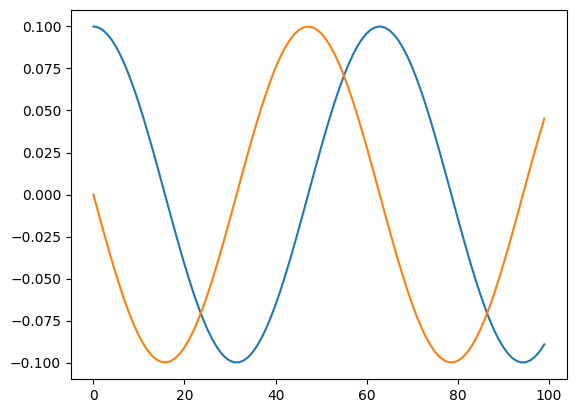

In [5]:
# checking whether the code is working so far
D = 1
L = 1
z0 = np.array([0.1])
dz0 = np.array([0.0])
coefficients = np.array([[-1.0]])

# Define terms as a vector of functions (sine function in this case)
terms = lambda z: np.sin(z)

T = 10.0
dt = 0.1
y0 = np.concatenate([z0, dz0])

result = simulate_pendulum(y0, coefficients, terms, T, dt)
plt.plot(result); print(np.shape(result)); print(np.shape(result[:,:D]))

yep. the code so far is working! let's proceed further.

In [6]:
def create_pendulum_data(z0_min, z0_max,
                         dz0_min, dz0_max,
                         coefficients, terms,
                         T, dt, N,
                         embedding=None, rejection=True, Dim=1):
    data_dict = {}

    for sim_run_num in tqdm(range(N), desc="Simulations"):
        while True:
            z0 = np.array([np.random.uniform(z0_min, z0_max)])
            dz0 = np.array([np.random.uniform(dz0_min, dz0_max)])

            if not rejection:
                break  # No rejection, proceed with the simulation

            angular_momentum = 0.5 * (dz0 ** 2) - np.cos(z0)
            #print("angular_momentum", np.abs(angular_momentum))

            if np.abs(angular_momentum) <= 0.99:
                break  # Angular momentum condition satisfied, proceed with the simulation

        simulation_result = simulate_pendulum(np.concatenate([z0, dz0]), coefficients, terms, T, dt)
        # D=np.shape(simulation_result)[1]//2
        # print("Dim is:", Dim)
        second_derivative = pendulum_rhs(simulation_result[:,:Dim], simulation_result[:,Dim:],
                                         coefficients, terms)

        if embedding is not None:
            # Add code for artificial embedding (needed later)
            pass

        data_dict[sim_run_num+1]={"z":simulation_result[:, :Dim],
                                  "dzdt":simulation_result[:, Dim:],
                                  "d2zdt":second_derivative}

        #data.append((simulation_result[:, :Dim], simulation_result[:, Dim:], second_derivative))#[D:]))

    return data_dict



Let's create the dataset {z , $\dot{z}$ , $\ddot{z}$}

In [109]:
z0_min = -np.pi
z0_max = np.pi
dz0_min = -2.1
dz0_max = 2.1
coefficients = np.array([[-1.0]])
terms_true = lambda z: np.sin(z)

T = 50.0
dt = 0.02
N =  10# number of simulation runs
embedding = None
rejection = True

training_data_dict = create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max,
                                     coefficients, terms_true, T, dt, N, embedding, rejection)

time=np.arange(0,T,step=dt)

# print("training_data dict:")
# print(training_data_dict)

Simulations: 100%|██████████| 10/10 [00:00<00:00, 72.05it/s]


Let's pick 5 simulations randomly and visualise {z , $\dot{z}$ , $\ddot{z}$}.

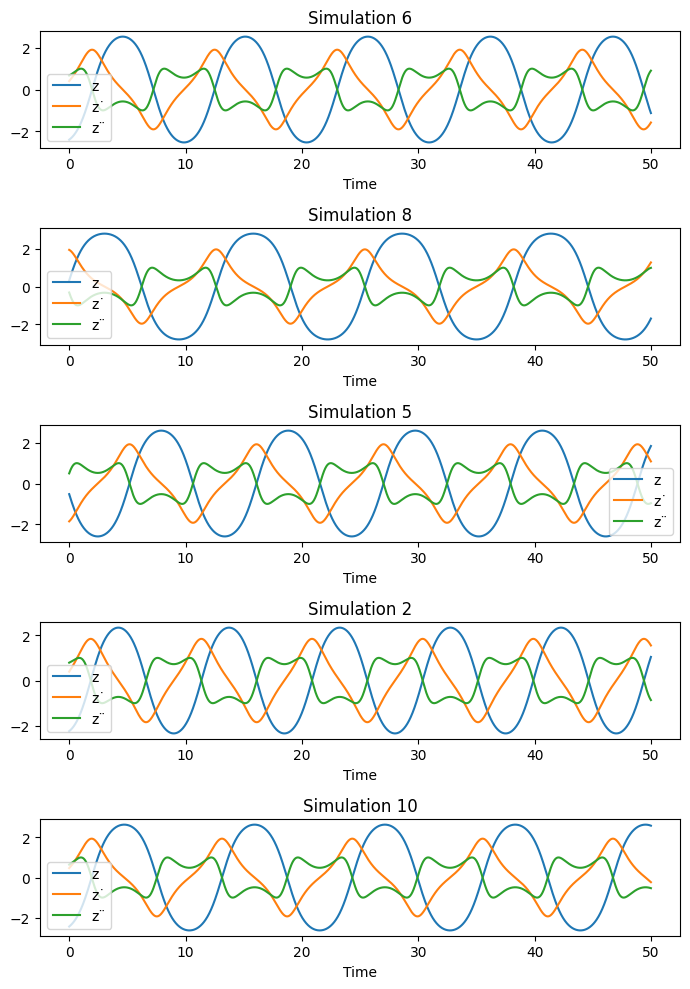

In [110]:
import matplotlib.pyplot as plt

# Choose 5 simulations randomly
selected_simulations = np.random.choice(N, 5, replace=False)

# Plot the selected simulations
fig, axs = plt.subplots(5, 1, figsize=(7, 10))

for i, sim_num in enumerate(selected_simulations):
    time_points = np.arange(0, T, step=dt)  # Assuming 'time' is not included in data_dict
    z_values = training_data_dict[sim_num+1]['z']  # zt
    dzdt_values = training_data_dict[sim_num+1]['dzdt']  # z˙t
    d2zdt_values = training_data_dict[sim_num+1]['d2zdt']  # z¨t

    # Plot z, z˙, and z¨ on the same plot
    axs[i].plot(time_points, z_values, label='z')
    axs[i].plot(time_points, dzdt_values, label='z˙')
    axs[i].plot(time_points, d2zdt_values, label='z¨')
    axs[i].set_title(f'Simulation {sim_num + 1}')
    axs[i].set_xlabel('Time')
    axs[i].legend()

plt.tight_layout()
plt.show()




Next step is to create the training data-set for the regression task.

In [111]:
# Extract arrays for "z", "dzdt", and "d2zdt"
z_arrays = [v["z"] for v in training_data_dict.values()]
dzdt_arrays = [v["dzdt"] for v in training_data_dict.values()]
d2zdt_arrays = [v["d2zdt"] for v in training_data_dict.values()]

# print(z_arrays)

# Concatenate along the first axis
concatenated_z = np.concatenate(z_arrays, axis=0)
concatenated_dzdt = np.concatenate(dzdt_arrays, axis=0)
concatenated_d2zdt = np.concatenate(d2zdt_arrays, axis=0)


print("Concatenated z:")
print(concatenated_z.shape) # number of datapoints (T*N,1)

Concatenated z:
(25000, 1)


In [ ]:
# z_diff_init_cond= np.concatenate(z_arrays, axis=1)
# dzdt_diff_init_cond= np.concatenate(dzdt_arrays, axis=1)
# d2zdt_diff_init_cond= np.concatenate(d2zdt_arrays, axis=1)
# z_diff_init_cond

### recall that T=50, dt=0.02 and N=100
# z_diff_init_cond.shape# this means data in i'th column correspond to i'th simualtion

1.2 Implementation and Training

In [112]:
### Based on our prior knowledge, defining our library matrix
def sin_term(z):
    return np.sin(z)

def cos_term(z):
    return np.cos(z)

def square(z):
  return z*z

def z_times_dzdt(z,dzdt):
  return z * dzdt


def term_vector(z,dzdt):
  to_return= np.array([np.ones(np.shape(z)), z, dzdt, sin_term(z),
                   square(z), z_times_dzdt(z,dzdt),
                   z*sin_term(z), square(dzdt),
                   dzdt * sin_term(z),
                   sin_term(z)*sin_term(z)
                   ])

  return to_return

For the regression task, $\mathbf{y}$ is $\ddot{z}$. Let's create our X dataset-library matrix.

In [113]:
# Creating the X matrix for the lasso regression

flattened_z = concatenated_z.flatten()
flattened_dzdt = concatenated_dzdt.flatten()

result = term_vector(flattened_z, flattened_dzdt)
# right now our X matrix (for Lasso) is of the shape (number of features X number of datapoints)
# let transpose it so that the shape of X matrix (for lasso) is (number of datapoints X no. of features)
X_for_regression=np.transpose(result)
print("X for regression is:")
print(X_for_regression); print(X_for_regression.shape); print(concatenated_z.shape)

X for regression is:
[[ 1.         -1.91737232  0.50448252 ...  0.25450262 -0.47448664
   0.88461791]
 [ 1.         -1.9070943   0.52332773 ...  0.27387192 -0.49401237
   0.89110349]
 [ 1.         -1.89643872  0.54224199 ...  0.29402637 -0.51374468
   0.89765281]
 ...
 [ 1.          2.59106727 -0.21084156 ...  0.04445416 -0.11029861
   0.27367029]
 [ 1.          2.58674557 -0.22134076 ...  0.04899173 -0.11660526
   0.27753229]
 [ 1.          2.58221314 -0.23191522 ...  0.05378467 -0.12306822
   0.28160045]]
(25000, 10)
(25000, 1)


Creating the trainig and test dataset and dataloaders

In [114]:
# creating training and the test set
X_train, X_test, y_train, y_test = train_test_split(X_for_regression,concatenated_d2zdt,
                                                    test_size=0.3,random_state=42)

In [115]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17500, 10), (7500, 10), (17500, 1), (7500, 1))

In [116]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create TensorDataset for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Set batch size for training and test DataLoader
batch_size = 32

# Create DataLoader for training set
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for test set
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Implementing SINDy using sklearn's LASSO

In [117]:
### checking the weights using the lasso regression
from sklearn.linear_model import Lasso

# Create Lasso model
lasso = Lasso(alpha=0.001, fit_intercept=False)

# Fit the model
lasso.fit(X_train, y_train)

# Access coefficients and intercept
coefficients = lasso.coef_
# intercept = lasso.intercept_

print("Coefficients:", coefficients)
# print("Intercept:", intercept)

Coefficients: [-0.         -0.00143436  0.         -0.99534981 -0.         -0.
 -0.          0.         -0.          0.        ]


As can be seen that coefficient corresponsing to sin(z) term is almost equal to -1. The other non-zero coefficient corresponds to the z term. It kinda makes sense because some points in our data belong to the initial points where small-angle approximation is valid.

In [118]:
### making predictions on the test dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = lasso.predict(X_test)

# Evaluate the performance using different metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 3.3542347119208606e-06
Mean Absolute Error (MAE): 0.001636707796998399
R-squared (R2) Score: 0.9999938337912714


* Let's implement the pytorch based `SINDy` regression

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [120]:
class SINDy(nn.Module):
    def __init__(self, input_size, output_size):
        super(SINDy, self).__init__()

        # Coefficient mask (boolean)
        self.mask = nn.Parameter(torch.ones(output_size, input_size,
                                            dtype=torch.bool), requires_grad=False)

        # Coefficient matrix
        self.coefficients = nn.Parameter(torch.ones(output_size, input_size,
                                                    dtype=torch.float32), requires_grad=True)

    def forward(self, x):
        # Apply boolean mask
        masked_coefficients = self.coefficients * self.mask.int().float()#self.mask

        # Linear combination of terms
        output = F.linear(x, masked_coefficients)

        return output

In [19]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# train and validate function without any thresholding
def train_and_validate_sindy(model, train_loader, val_loader,
                             num_epochs=100, print_epoch=1,
                             learning_rate=0.001):
    # Define optimizer and criterion inside the function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Lists to store average epoch losses for training and validation
    avg_epoch_train_losses = []
    avg_epoch_val_losses = []

    # List to store coefficient values over time
    coefficient_values_over_time = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            sindy_coefficients= model.coefficients.detach()
            l1_norm = torch.norm(sindy_coefficients, p=1).item()
            loss = criterion(outputs, targets) + (0.00001)*l1_norm
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                sindy_coefficients= model.coefficients.detach()
                l1_norm = torch.norm(sindy_coefficients, p=1).item()
                loss = criterion(outputs, targets) + (0.00001)*l1_norm
                #loss = criterion(outputs, targets)

                val_loss += loss.item()

        # Average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)

        # Log average epoch losses
        avg_epoch_train_losses.append(avg_train_loss)
        avg_epoch_val_losses.append(avg_val_loss)

        # Log coefficient values
        #print("coefficients right now:")
        coefficients_snapshot = model.coefficients.detach().clone().numpy()
        #print(coefficients_snapshot)
        coefficient_values_over_time.append(coefficients_snapshot)

        # Print average epoch losses after print_epoch number of epochs
        if epoch % print_epoch == 0:
            print(f'Epoch {epoch}/{num_epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}')

    return avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time


In [21]:
def plot_train_and_val_loss(train_loss, val_loss, want_logscale=True):
  plt.plot(train_loss,"-",label="train loss")
  plt.plot(val_loss, ":", label="val loss")
  plt.xlabel("epochs")
  plt.ylabel("average epoch loss")
  if want_logscale:
    plt.yscale('log')
  plt.legend()

In [22]:
# training the model
input_size = 10
output_size = 1

# Create SINDy model
sindy_model = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time = train_and_validate_sindy(sindy_model,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005)


Epoch 1/10, Avg. Training Loss: 6.637205489908925, Avg. Validation Loss: 0.027478063854535106
Epoch 2/10, Avg. Training Loss: 0.010339177759380543, Avg. Validation Loss: 0.00011325622661717511
Epoch 3/10, Avg. Training Loss: 1.5819386614539505e-05, Avg. Validation Loss: 1.0004224131819034e-05
Epoch 4/10, Avg. Training Loss: 1.0000380600488594e-05, Avg. Validation Loss: 1.0000054325597071e-05
Epoch 5/10, Avg. Training Loss: 1.0096407434679685e-05, Avg. Validation Loss: 1.0000001566368155e-05
Epoch 6/10, Avg. Training Loss: 1.0066681051690437e-05, Avg. Validation Loss: 1.0000003385357559e-05
Epoch 7/10, Avg. Training Loss: 1.006159370518652e-05, Avg. Validation Loss: 1.0007373964953589e-05
Epoch 8/10, Avg. Training Loss: 1.0067560665774451e-05, Avg. Validation Loss: 1.0000027607250157e-05
Epoch 9/10, Avg. Training Loss: 1.0069736599336793e-05, Avg. Validation Loss: 1.0205216271768365e-05
Epoch 10/10, Avg. Training Loss: 1.0051770548261471e-05, Avg. Validation Loss: 1.0049361954994068e-05

In [23]:
coefficient_values_over_time

[array([[-0.01272632, -0.28575343,  0.00480535, -0.4593579 ,  0.00684609,
          0.01586027, -0.00483591,  0.00602205, -0.02075604, -0.00429589]],
       dtype=float32),
 array([[-2.46277661e-04, -1.81454830e-02, -1.07984255e-04,
         -9.67298746e-01,  4.02338163e-04,  3.70520889e-03,
         -2.67176260e-03,  1.77147289e-04, -4.93062288e-03,
          3.28389183e-03]], dtype=float32),
 array([[-1.3676514e-05, -3.1911784e-06, -2.3296489e-06, -9.9999726e-01,
          2.6721482e-05, -1.5874080e-06, -1.5294460e-04,  2.1297851e-06,
          4.5338488e-06,  1.8502987e-04]], dtype=float32),
 array([[-9.7466898e-07, -2.4280993e-07,  7.1483714e-07, -9.9999994e-01,
          1.5916433e-07,  7.6201849e-07, -3.5960798e-07, -4.3181728e-07,
          1.2850804e-06,  1.2521450e-07]], dtype=float32),
 array([[-1.1377104e-08, -3.6835580e-08,  2.2666240e-08, -9.9999994e-01,
          5.2203220e-10,  9.4667804e-08, -1.7284769e-09,  3.7893457e-08,
          2.3305246e-08, -1.8903119e-08]], dtyp

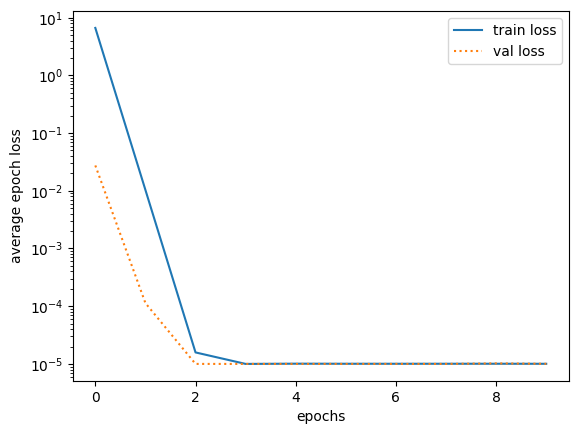

In [24]:
plot_train_and_val_loss(avg_epoch_train_losses,
                        avg_epoch_val_losses
                        )

In [25]:
# Accessing all model parameters (including coefficients)
all_parameters = list(sindy_model.parameters())

# Accessing the coefficient matrix (excluding the boolean mask)
coefficients_matrix = all_parameters[1].detach().numpy()

# Accessing the boolean mask
boolean_mask = sindy_model.mask.detach().numpy()

# Printing the results
#print("All Parameters (including coefficients):", all_parameters)
print("Coefficients:", coefficients_matrix)
print("Boolean Mask:", boolean_mask)

Coefficients: [[ 3.3632175e-05  7.7970020e-05  2.8795752e-05 -1.0000306e+00
   7.5603071e-05  1.0455627e-04 -6.9931877e-05  2.6382295e-05
  -2.1018952e-05  3.7167287e-05]]
Boolean Mask: [[ True  True  True  True  True  True  True  True  True  True]]


1.3. Implementing the thresholding

In [26]:
def sequential_thresholding(coefficients, mask, epoch, threshold_a, interval):
    # Apply thresholding every 'interval' epochs
    # if interval > 0 and (epoch % interval == 0):
    # Identify small coefficients
    small_coefficients = torch.abs(coefficients) < threshold_a

    # Zero out small coefficients
    with torch.no_grad():
        # Zero out small coefficients
        coefficients[small_coefficients] = 0.0

    # Update the mask for coefficients smaller than a
    mask[small_coefficients] = False

In [27]:
def PTA_thresholding(coefficients, mask,
                     epoch, threshold_a, threshold_b,
                     patience_p, E_a, E_b, previous_coefficients):


    ## Identify coefficients exceeding thresholds
    coefficients_exceeding_a = torch.abs(coefficients) > threshold_a
    coefficients_exceeding_b = torch.abs(coefficients - previous_coefficients) > threshold_b

    ## Update exceeded threshold epochs
    E_a[coefficients_exceeding_a] = epoch
    E_b[coefficients_exceeding_b] = epoch

    ## Element-wise OR to create Υ˜
    mask_tilde = ((epoch - E_a) < patience_p) | ((epoch - E_b) < patience_p)

    ## Update the coefficient mask
    new_mask = mask & mask_tilde

    locations_false = ~new_mask
    mask[locations_false] = False

    ## Clone the coefficients for the next epoch
    previous_coefficients = coefficients.clone().detach()# This ensures that the previous_coefficients tensor is detached from the computation graph
    return previous_coefficients

Let's include thresholding in the train_and_validate_sindy function.

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_and_validate_sindy(model, train_loader, val_loader,
                             num_epochs=100, print_epoch=1,
                             learning_rate=0.001, thresholding=None, threshold_a=1e-3,interval=10,
                             threshold_b=1e-4, patience_p=4):

    #print("interval value is:", interval)
    # Define optimizer and criterion inside the function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Lists to store average epoch losses for training and validation
    avg_epoch_train_losses = []
    avg_epoch_val_losses = []

    # List to store coefficient values over time
    coefficient_values_over_time = []

    ### initialising some additional params if thresholding is "paitence"
    if thresholding == "patient":
      E_a= torch.zeros_like(model.coefficients)
      E_b= torch.zeros_like(model.coefficients)
      previous_coefficients = torch.zeros_like(model.coefficients)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            sindy_coefficients= model.coefficients.detach()
            l1_norm = torch.norm(sindy_coefficients, p=1).item()
            loss = criterion(outputs, targets) + (0.00001)*l1_norm

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Average training loss for the epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)

                sindy_coefficients= model.coefficients.detach()
                l1_norm = torch.norm(sindy_coefficients, p=1).item()
                loss = criterion(outputs, targets) + (0.00001)*l1_norm

                val_loss += loss.item()

        # Average validation loss for the epoch
        avg_val_loss = val_loss / len(val_loader)

        # Log average epoch losses
        avg_epoch_train_losses.append(avg_train_loss)
        avg_epoch_val_losses.append(avg_val_loss)

        # Apply Sequential Thresholding (ST) if specified
        if thresholding == "sequential":
            if (epoch % interval == 0):
              #print("----applying ST----")
              sequential_thresholding(model.coefficients, model.mask, epoch, threshold_a, interval)

        if thresholding == "patient":
            print("---applying PTAT -----")
            #* self.mask.int().float()
            #add_1000(model.coefficients)
            previous_coefficients= PTA_thresholding(model.coefficients #* model.mask.int().float()
                      , model.mask,
                     epoch, threshold_a, threshold_b,
                     patience_p, E_a, E_b, previous_coefficients)

        # Log coefficient values
        #print("coefficients right now:")
        coefficients_snapshot = model.coefficients.detach().clone().numpy()
        #print(coefficients_snapshot)
        #print("masked coefficients:")
        #print((model.coefficients.detach().clone() * model.mask.detach().int().float()).numpy())
        #print("boolean matrix:")
        #print(model.mask.detach().numpy())
        coefficient_values_over_time.append((model.coefficients.detach().clone() * model.mask.detach().int().float()).numpy().flatten())


        # Print average epoch losses after print_epoch number of epochs
        if epoch % print_epoch == 0:
            print(f'Epoch {epoch}/{num_epochs}, Avg. Training Loss: {avg_train_loss}, Avg. Validation Loss: {avg_val_loss}')
            print("_"*50)
    return avg_epoch_train_losses, avg_epoch_val_losses, coefficient_values_over_time

Let's train models with different thresholding schemes:

Sequential Thresholding

In [29]:
# training the model with sequential thresholding
input_size = 10
output_size = 1

# Create SINDy model
sindy_model_ST = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses_ST, avg_epoch_val_losses_ST, coefficient_values_over_time_ST = train_and_validate_sindy(sindy_model_ST,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005,
                                                                                                      thresholding="sequential",
                                                                                                      threshold_a=0.00001,
                                                                                                      interval=2)


Epoch 1/10, Avg. Training Loss: 6.600107962840003, Avg. Validation Loss: 0.02747009697397249
__________________________________________________
Epoch 2/10, Avg. Training Loss: 0.0103062116625369, Avg. Validation Loss: 0.00011308490341934419
__________________________________________________
Epoch 3/10, Avg. Training Loss: 1.5721046248336504e-05, Avg. Validation Loss: 1.0003035782704815e-05
__________________________________________________
Epoch 4/10, Avg. Training Loss: 1.0000275377655689e-05, Avg. Validation Loss: 1.0000117383379047e-05
__________________________________________________
Epoch 5/10, Avg. Training Loss: 1.0000479090499686e-05, Avg. Validation Loss: 1.0000479960581288e-05
__________________________________________________
Epoch 6/10, Avg. Training Loss: 1.0000479960581288e-05, Avg. Validation Loss: 1.0000479960581288e-05
__________________________________________________
Epoch 7/10, Avg. Training Loss: 1.0000113434216473e-05, Avg. Validation Loss: 1.0000113434216473e-05

In [30]:
# Accessing all model parameters (including coefficients)
all_parameters_ST = list(sindy_model_ST.parameters())

# Accessing the coefficient matrix (excluding the boolean mask)
coefficients_matrix_ST = all_parameters_ST[1].detach().numpy()

# Accessing the boolean mask
boolean_mask_ST = sindy_model_ST.mask.detach().numpy()

# Printing the results
#print("All Parameters (including coefficients):", all_parameters)
print("Coefficients:", coefficients_matrix_ST)
print("Boolean Mask:", boolean_mask_ST)

Coefficients: [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  1.1331115e-05
   0.0000000e+00  0.0000000e+00]]
Boolean Mask: [[False False False  True False False False False False False]]


Plotting coefficient history for SINDy with ST

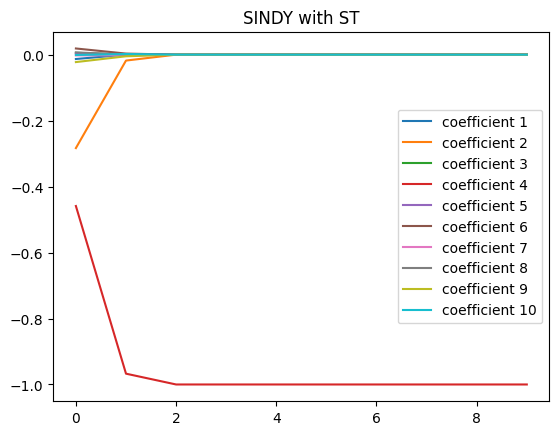

In [31]:
coefficient_array_ST= np.array(coefficient_values_over_time_ST)
for i in range(0,10):
    plt.plot(coefficient_array_ST[:,i], label=f"coefficient {i+1}")
plt.legend()
plt.title("SINDY with ST")
plt.show()

PTAT Thresholding

In [32]:
# training the model with PTAT thresholding
input_size = 10
output_size = 1

# Create SINDy model
sindy_model_PTAT = SINDy(input_size, output_size)


# Assuming sindy_model, train_loader, and test_loader are already defined
avg_epoch_train_losses_ptat, avg_epoch_val_losses_ptat, coefficient_values_over_time_ptat = train_and_validate_sindy(sindy_model_PTAT,
                                                                                                      train_loader,
                                                                                                      test_loader,
                                                                                                      num_epochs=10,
                                                                                                      learning_rate=0.0005,
                                                                                                      thresholding="patient",
                                                                                                      threshold_a=0.001,
                                                                                                      threshold_b=0.0001,
                                                                                                      patience_p=2)


---applying PTAT -----
Epoch 1/10, Avg. Training Loss: 6.531276081257695, Avg. Validation Loss: 0.027540454766140938
__________________________________________________
---applying PTAT -----
Epoch 2/10, Avg. Training Loss: 0.010323682751803464, Avg. Validation Loss: 0.00010718110556172488
__________________________________________________
---applying PTAT -----
Epoch 3/10, Avg. Training Loss: 1.537472962094171e-05, Avg. Validation Loss: 1.0003622016449714e-05
__________________________________________________
---applying PTAT -----
Epoch 4/10, Avg. Training Loss: 1.0000329426652494e-05, Avg. Validation Loss: 1.000008508972097e-05
__________________________________________________
---applying PTAT -----
Epoch 5/10, Avg. Training Loss: 1.008172329348956e-05, Avg. Validation Loss: 1.0013625809805033e-05
__________________________________________________
---applying PTAT -----
Epoch 6/10, Avg. Training Loss: 1.0008594464328106e-05, Avg. Validation Loss: 1.0008600838773418e-05
_____________

In [33]:
coefficient_array_ptat= np.array(coefficient_values_over_time_ptat)

Plotting coefficients obtained for SINDy with PTAT:

Text(0.5, 1.0, 'SINDy with PTAT')

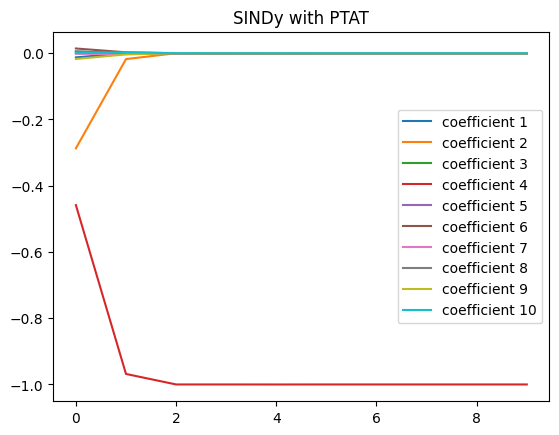

In [34]:
for i in range(0,10):
    plt.plot(coefficient_array_ptat[:,i], label=f"coefficient {i+1}")
plt.legend()
plt.title("SINDy with PTAT")

### 2. SINDy-Autoencoder

2.1 Cartesian Embedding:

In [121]:
def cartesian_embedding(z_in, dzdt_in, d2zdt_in):

  ##x
  x1=np.sin(z_in)
  x2= -np.cos(z_in)
  x=np.concatenate([x1,x2],axis=1)

  ## dxdt
  x1_dot= np.cos(z_in)* dzdt_in
  x2_dot= np.sin(z_in)* dzdt_in
  xdot= np.concatenate([x1_dot, x2_dot], axis=1)

  ## d2zdt
  x1_ddot= -np.sin(z_in)* (dzdt_in*dzdt_in) + np.cos(z_in)* d2zdt_in
  x2_ddot = np.cos(z_in)* (dzdt_in*dzdt_in) + np.sin(z_in)* d2zdt_in
  xddot= np.concatenate([x1_ddot, x2_ddot], axis=1)

  return x, xdot, xddot


In [122]:
concatenated_z.shape,concatenated_dzdt.shape,concatenated_d2zdt.shape

((25000, 1), (25000, 1), (25000, 1))

In [123]:
# creating the data in x domain.
x,xdot,xddot=cartesian_embedding(concatenated_z,concatenated_dzdt,concatenated_d2zdt)
x.shape, xdot.shape, xddot.shape

((25000, 2), (25000, 2), (25000, 2))

let's create the train and test dataset and dataloaders for this training set

In [124]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# defining the custom dataset
class CustomDataset_simple_AE(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [125]:
# Split the dataset into train and test sets
cart_x_train, cart_x_test = train_test_split(x, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
cart_x_train_tensor = torch.Tensor(cart_x_train)
cart_x_test_tensor = torch.Tensor(cart_x_test)

# Create custom datasets and dataloaders
batch_size = 64

# Training dataset and dataloader
train_dataset = CustomDataset_simple_AE(cart_x_train_tensor)
cartesian_x_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing dataset and dataloader
test_dataset = CustomDataset_simple_AE(cart_x_test_tensor)
cartesian_x_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2.2 Autoencoder and hyperparameter optimization

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [41]:
# simple Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_size, num_layers,hidden_size):
        super(Autoencoder, self).__init__()

        # Encoder layers
        encoder_layers = [nn.Linear(input_size, hidden_size[0]), nn.Sigmoid()]
        for i in range(1, num_layers):
            encoder_layers.append(nn.Linear(hidden_size[i-1], hidden_size[i]))
            encoder_layers.append(nn.Sigmoid())
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers
        decoder_layers = []
        for i in range(1,num_layers,1):
            decoder_layers.append(nn.Linear(hidden_size[-i], hidden_size[-i-1]))
            decoder_layers.append(nn.Sigmoid())
        decoder_layers.append(nn.Linear(hidden_size[-num_layers], input_size))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [42]:
# 2. train_and_validate_simple_AE() function
def train_and_validate_simple_AE(model, train_dataloader, val_dataloader, num_epochs=50,
                                 learning_rate=1e-3,
                                 print_epoch=1):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    avg_epoch_train_loss = []
    avg_epoch_val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for data in train_dataloader:
            inputs = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_epoch_train_loss.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for data in val_dataloader:
                inputs = data
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_epoch_val_loss.append(avg_val_loss)

        if (epoch + 1) % print_epoch == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}],Train Loss: {avg_train_loss:.8f} and  Validation Loss: {avg_val_loss:.8f}')

    return avg_epoch_train_loss, avg_epoch_val_loss


Hyperparameter search:

Let's first check the performance with different number of layers.

In [ ]:
### let's check:
input_size=2
num_layers=1
hidden_size=[1]
simple_AE_model= Autoencoder(input_size=input_size, num_layers=num_layers,
                             hidden_size=hidden_size)

avg_train_loss_simple_ae, avg_val_loss_simple_ae= train_and_validate_simple_AE(simple_AE_model,
                                                                      cartesian_x_train_dataloader,
                                                                      cartesian_x_test_dataloader,
                                                                      num_epochs=10,
                                                                      learning_rate=1e-3
                                                                              )

plot_train_and_val_loss(avg_train_loss_simple_ae, avg_val_loss_simple_ae)

In [ ]:
### let's check:
input_size=2
num_layers=2
hidden_size=[2,1]
simple_AE_model= Autoencoder(input_size=input_size, num_layers=num_layers,
                             hidden_size=hidden_size)

avg_train_loss_simple_ae, avg_val_loss_simple_ae= train_and_validate_simple_AE(simple_AE_model,
                                                                      cartesian_x_train_dataloader,
                                                                      cartesian_x_test_dataloader,
                                                                      num_epochs=10,
                                                                      learning_rate=1e-3
                                                                              )

plot_train_and_val_loss(avg_train_loss_simple_ae, avg_val_loss_simple_ae)

In [ ]:
### let's check:
input_size=2
num_layers=2
hidden_size=[4,1]
simple_AE_model= Autoencoder(input_size=input_size, num_layers=num_layers,
                             hidden_size=hidden_size)

avg_train_loss_simple_ae, avg_val_loss_simple_ae= train_and_validate_simple_AE(simple_AE_model,
                                                                      cartesian_x_train_dataloader,
                                                                      cartesian_x_test_dataloader,
                                                                      num_epochs=10,
                                                                      learning_rate=1e-3
                                                                              )

plot_train_and_val_loss(avg_train_loss_simple_ae, avg_val_loss_simple_ae)

In [ ]:
### let's check:
input_size=2
num_layers=3
hidden_size_list=[2,2,1]
simple_AE_model_2= Autoencoder(input_size=input_size, num_layers=num_layers,
                             hidden_size=hidden_size_list)

avg_train_loss_simple_ae2, avg_val_loss_simple_ae2= train_and_validate_simple_AE(simple_AE_model_2,
                                                                      cartesian_x_train_dataloader,
                                                                      cartesian_x_test_dataloader,
                                                                      num_epochs=10,
                                                                      learning_rate=1e-3
                                                                              )

plot_train_and_val_loss(avg_train_loss_simple_ae2, avg_val_loss_simple_ae2)

In [ ]:
### let's check:
input_size=2
num_layers=3
hidden_size_list=[2,1,1]
simple_AE_model_2= Autoencoder(input_size=input_size, num_layers=num_layers,
                             hidden_size=hidden_size_list)

avg_train_loss_simple_ae2, avg_val_loss_simple_ae2= train_and_validate_simple_AE(simple_AE_model_2,
                                                                      cartesian_x_train_dataloader,
                                                                      cartesian_x_test_dataloader,
                                                                      num_epochs=10,
                                                                      learning_rate=1e-3
                                                                              )

plot_train_and_val_loss(avg_train_loss_simple_ae2, avg_val_loss_simple_ae2)

based on this, let's choose the architecture:

num_layers=2, hidden_size_list=[2,1]

Let's us now check for effect of different learning rate:

In [ ]:
# Function to train and validate with different learning rates
def check_learning_rates(input_size, num_layers, hidden_size_list, learning_rates, num_epochs=10):
    losses_dict = {}

    for learning_rate in learning_rates:
        print(f"---------------learning rate is:{learning_rate}----------")

        # Create Autoencoder model
        simple_AE_model = Autoencoder(input_size=input_size, num_layers=num_layers,
                                      hidden_size=hidden_size_list)

        # if learning_rate == 0.0001:
        #   num_epochs=40

        # Train and validate the model
        avg_train_loss, avg_val_loss = train_and_validate_simple_AE(
            simple_AE_model,
            cartesian_x_train_dataloader,
            cartesian_x_test_dataloader,
            num_epochs=num_epochs,
            learning_rate=learning_rate
        )

        # Store losses in dictionary
        losses_dict[f'Learning Rate={learning_rate}'] = (avg_train_loss, avg_val_loss)

    return losses_dict

# Hyperparameters
input_size = 2
num_layers = 2
hidden_size_list = [2, 1]
learning_rates = [1e-3, 5e-4, 1e-4]

# Check different learning rates
losses_dict = check_learning_rates(input_size, num_layers,
                                   hidden_size_list, learning_rates,
                                   num_epochs=10)

# Print the final losses for each learning rate
for config, (train_loss, val_loss) in losses_dict.items():
     print(f'Configuration: {config}, Final Train Loss: {train_loss[-1]:.8f}, Final Validation Loss: {val_loss[-1]:.8f}')

In [43]:
def plot_losses(losses_dict):
    plt.figure(figsize=(10, 6))

    for config, (train_loss, val_loss) in losses_dict.items():
        epochs = range(1, len(train_loss) + 1)
        plt.plot(epochs, train_loss, label=f'Train Loss ({config})')
        plt.plot(epochs, val_loss, label=f'Validation Loss ({config})', linestyle='dashed')

    plt.title('Train and Validation Loss for Different Learning Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# Plot losses for different learning rate cases together
# plot_losses(losses_dict)

Based on this test, we chose the learning rate to be: 0.001

2.3 Propagation of Time Derivatives:

In [127]:
import torch
import torch.nn as nn

class SigmoidDerivatives(nn.Module):
    def dg(self, z_in):
        return torch.sigmoid(z_in) * (1 - torch.sigmoid(z_in))

    def ddg(self, z_in):
        return self.dg(z_in) * (1 - 2 * torch.sigmoid(z_in))

    def forward(self, z_tilde_l, dz_tilde_l, ddz_tilde_l):
        z_l = torch.sigmoid(z_tilde_l)
        dz_l = self.dg(z_tilde_l) * dz_tilde_l
        ddz_l = (self.ddg(z_tilde_l) * dz_tilde_l) * dz_tilde_l + self.dg(z_tilde_l) * ddz_tilde_l
        return z_l, dz_l, ddz_l

class LinearDerivatives(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearDerivatives, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, z_l, dz_l, ddz_l, include_bias=True):
        # Include bias for z_tilde_l
        z_tilde_l = self.linear(z_l)

        # Exclude bias for derivatives
        if include_bias:
            dz_tilde_l = self.linear(dz_l)
            ddz_tilde_l = self.linear(ddz_l)
        else:
            dz_tilde_l = self.linear(dz_l) - self.linear.bias
            ddz_tilde_l = self.linear(ddz_l) - self.linear.bias

        return z_tilde_l, dz_tilde_l, ddz_tilde_l

# class Encoder(nn.Module):
#     def __init__(self, input_size, num_layers, hidden_size_list):
#         super(Encoder, self).__init__()

#         #CORRECT IMPLEMENTATION:
#         encoder_layers= [LinearDerivatives(input_size, hidden_size_list[0]), SigmoidDerivatives()]
#         for i in range(1,num_layers):
#           encoder_layers.append(LinearDerivatives(hidden_size_list[i-1],hidden_size_list[i]))
#           encoder_layers.append(SigmoidDerivatives())
#         self.encoder = nn.Sequential(*encoder_layers)

#     def forward(self, x, dx, ddx):
#         z_l, dz_l, ddz_l = x.clone(), dx.clone(), ddx.clone()  # initializing
#         for layer in self.encoder:
#             if isinstance(layer, LinearDerivatives):
#                 z_tilde_l, dz_tilde_l, ddz_tilde_l = layer(z_l, dz_l, ddz_l, include_bias=False)
#             elif isinstance(layer, SigmoidDerivatives):
#                 z_l, dz_l, ddz_l = layer(z_tilde_l, dz_tilde_l, ddz_tilde_l)

#         return z_l, dz_l, ddz_l

# class Decoder(nn.Module):
#     def __init__(self, num_layers, hidden_size_list, output_size):
#         super(Decoder, self).__init__()

#         #CORRECT IMPLEMENTATION
#         decoder_layers=[]
#         for i in range(1, num_layers, 1):
#           decoder_layers.append(LinearDerivatives(hidden_size_list[-i],hidden_size_list[-i-1]))
#           decoder_layers.append(SigmoidDerivatives())
#         decoder_layers.append(LinearDerivatives(hidden_size_list[-num_layers],output_size))
#         decoder_layers.append(SigmoidDerivatives())
#         self.decoder = nn.Sequential(*decoder_layers)

#     def forward(self, z_l, dz_l, ddz_l):
#         # decoder part
#         x_l, dx_l, ddx_l = z_l.clone(), dz_l.clone(), ddz_l.clone()
#         for layer in self.decoder:
#             if isinstance(layer, LinearDerivatives):
#                 x_tilde_l, dx_tilde_l, ddx_tilde_l = layer(x_l, dx_l, ddx_l, include_bias=False)
#             elif isinstance(layer, SigmoidDerivatives):
#                 x_l, dx_l, ddx_l = layer(x_tilde_l, dx_tilde_l, ddx_tilde_l)

#         # The final output should be the reconstructed Cartesian coordinates
#         reconstructed_x = x_l.clone()
#         reconstructed_dx = dx_l.clone()
#         reconstructed_ddx = ddx_l.clone()

#         return reconstructed_x, reconstructed_dx, reconstructed_ddx

# class CustomAutoencoder(nn.Module):
#     def __init__(self, input_size, num_layers, hidden_size):
#         super(CustomAutoencoder, self).__init__()

#         self.encoder = Encoder(input_size, num_layers, hidden_size)
#         self.decoder = Decoder(num_layers, hidden_size, input_size)

#     def forward(self, x, dx, ddx):
#         z_l, dz_l, ddz_l = self.encoder(x, dx, ddx)

#         reconstructed_x, reconstructed_dx, reconstructed_ddx = self.decoder(z_l, dz_l, ddz_l)

#         return reconstructed_x, reconstructed_dx, reconstructed_ddx, z_l, dz_l, ddz_l


In [128]:
import torch.nn.init as init

class Encoder(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size_list, xavier_init=True):
        super(Encoder, self).__init__()

        encoder_layers = [LinearDerivatives(input_size, hidden_size_list[0]), SigmoidDerivatives()]
        for i in range(1, num_layers):
            encoder_layers.append(LinearDerivatives(hidden_size_list[i - 1], hidden_size_list[i]))
            encoder_layers.append(SigmoidDerivatives())
        self.encoder = nn.Sequential(*encoder_layers)

        # Initialize weights using Xavier initialization
        if xavier_init:
          self.init_weights()

    def init_weights(self):
        # Initialize encoder weights using Xavier initialization
        for layer in self.encoder.modules():
            if isinstance(layer, LinearDerivatives):
                init.xavier_uniform_(layer.linear.weight)
                if layer.linear.bias is not None:
                    layer.linear.bias.data.fill_(0)

    def forward(self, x, dx, ddx):
        z_l, dz_l, ddz_l = x.clone(), dx.clone(), ddx.clone()  # initializing
        for layer in self.encoder:
            if isinstance(layer, LinearDerivatives):
                z_tilde_l, dz_tilde_l, ddz_tilde_l = layer(z_l, dz_l, ddz_l, include_bias=False)
            elif isinstance(layer, SigmoidDerivatives):
                z_l, dz_l, ddz_l = layer(z_tilde_l, dz_tilde_l, ddz_tilde_l)

        return z_l, dz_l, ddz_l

class Decoder(nn.Module):
    def __init__(self, num_layers, hidden_size_list, output_size, xavier_init=True):
        super(Decoder, self).__init__()

        decoder_layers = []
        for i in range(1, num_layers, 1):
            decoder_layers.append(LinearDerivatives(hidden_size_list[-i], hidden_size_list[-i - 1]))
            decoder_layers.append(SigmoidDerivatives())
        decoder_layers.append(LinearDerivatives(hidden_size_list[-num_layers], output_size))
        decoder_layers.append(SigmoidDerivatives())
        self.decoder = nn.Sequential(*decoder_layers)

        # Initialize weights using Xavier initialization
        if xavier_init:
          self.init_weights()

    def init_weights(self):
        # Initialize decoder weights using Xavier initialization
        for layer in self.decoder.modules():
            if isinstance(layer, LinearDerivatives):
                init.xavier_uniform_(layer.linear.weight)
                if layer.linear.bias is not None:
                    layer.linear.bias.data.fill_(0)

    def forward(self, z_l, dz_l, ddz_l):
        # decoder part
        x_l, dx_l, ddx_l = z_l.clone(), dz_l.clone(), ddz_l.clone()
        for layer in self.decoder:
            if isinstance(layer, LinearDerivatives):
                x_tilde_l, dx_tilde_l, ddx_tilde_l = layer(x_l, dx_l, ddx_l, include_bias=False)
            elif isinstance(layer, SigmoidDerivatives):
                x_l, dx_l, ddx_l = layer(x_tilde_l, dx_tilde_l, ddx_tilde_l)

        # The final output should be the reconstructed Cartesian coordinates
        reconstructed_x = x_l.clone()
        reconstructed_dx = dx_l.clone()
        reconstructed_ddx = ddx_l.clone()

        return reconstructed_x, reconstructed_dx, reconstructed_ddx


Let's verify our implementation by comparing the propagated time derivatives with the discrete first and second order derivatives:

Creating the required data and dataloaders for this task:

In [129]:
z_diff_init_cond= np.concatenate(z_arrays, axis=1)
dzdt_diff_init_cond= np.concatenate(dzdt_arrays, axis=1)
d2zdt_diff_init_cond= np.concatenate(d2zdt_arrays, axis=1)
# print(z_diff_init_cond);
print(z_diff_init_cond.shape)

(2500, 10)


In [130]:
# let's take one of the simulations
x_1, xdot_1,xddot_1= cartesian_embedding(z_diff_init_cond[:,0][:,np.newaxis],
                                   dzdt_diff_init_cond[:,0][:,np.newaxis],
                                   d2zdt_diff_init_cond[:,0][:,np.newaxis])
x_1.shape, xdot_1.shape, xddot_1.shape

((2500, 2), (2500, 2), (2500, 2))

In [131]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

#
class CustomDataset_modified_AE(Dataset):
    def __init__(self, data_x1, data_x2, data_x3):
        self.data_x1 = data_x1
        self.data_x2 = data_x2
        self.data_x3 = data_x3

    def __len__(self):
        # all components have the same length
        return len(self.data_x1)

    def __getitem__(self, idx):
        sample_x1 = self.data_x1[idx]
        sample_x2 = self.data_x2[idx]
        sample_x3 = self.data_x3[idx]

        return sample_x1, sample_x2, sample_x3

In [132]:
# Split the dataset into train and test sets
cart_x1_train, cart_x1_test = train_test_split(x_1, test_size=0.5,shuffle=False)
cart_x1dot_train, cart_x1dot_test = train_test_split(xdot_1, test_size=0.5, shuffle=False)
cart_x1ddot_train, cart_x1ddot_test = train_test_split(xddot_1, test_size=0.5, shuffle=False)

# Convert numpy arrays to PyTorch tensors
cart_x1_train_tensor = torch.Tensor(cart_x1_train)
cart_x1_test_tensor = torch.Tensor(cart_x1_test)
cart_x1dot_train_tensor = torch.Tensor(cart_x1dot_train)
cart_x1dot_test_tensor = torch.Tensor(cart_x1dot_test)
cart_x1ddot_train_tensor = torch.Tensor(cart_x1ddot_train)
cart_x1ddot_test_tensor = torch.Tensor(cart_x1ddot_test)

# Create custom datasets and dataloaders
batch_size = np.shape(cart_x1_train)[0]

# Training dataset and dataloader
train_dataset1 = CustomDataset_modified_AE(cart_x1_train_tensor, cart_x1dot_train_tensor,cart_x1ddot_train_tensor )
cartesian_x1_train_dataloader = DataLoader(train_dataset1, batch_size=batch_size, shuffle=False)


# Testing dataset and dataloader
test_dataset1 = CustomDataset_modified_AE(cart_x1_test_tensor, cart_x1dot_test_tensor,cart_x1ddot_test_tensor)
cartesian_x1_test_dataloader = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)


In [133]:
# Function to compute discrete derivatives
def compute_discrete_derivatives(z_values):
    dz = (z_values[2:] - z_values[:-2]) / (2 * delta_t)
    ddz = (z_values[:-2] - 2 * z_values[1:-1] + z_values[2:]) / (delta_t ** 2)
    return dz, ddz

# Verify the implementation
def verify(encoder, dataloader):
    encoder.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch in dataloader:
            x, dx, ddx = batch
            z, dz, ddz = encoder(x, dx, ddx)

            # Convert z to numpy for computing discrete derivatives
            z_values = z.cpu().numpy()

            # Compute discrete derivatives
            discrete_dz, discrete_ddz = compute_discrete_derivatives(z_values)

            # Compare the predicted derivatives with discrete derivatives
        return z, dz, ddz, discrete_dz, discrete_ddz

In [134]:
# Use the verify function with your encoder and dataloader
delta_t = 0.02
input_size=2
num_layers=1
hidden_size_list=[1]

encoder_check = Encoder(input_size, num_layers, hidden_size_list= hidden_size_list)

z_out, dz_out, ddz_out, discrete_dz_out, discrete_ddz_out= verify(encoder_check,
                                                                  cartesian_x1_train_dataloader)


Let's plot and compare the derivatives obtained from the encoder model with derivvatives obtained using discrete-difference formula.

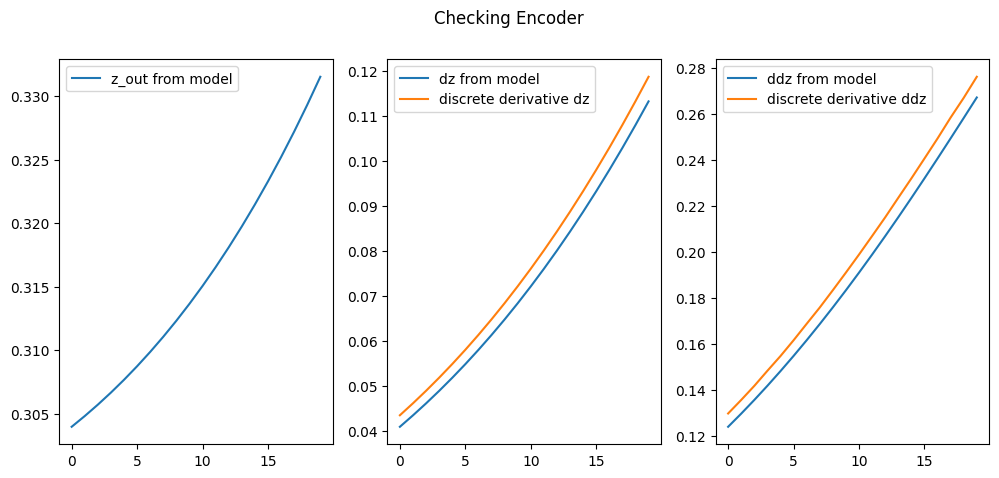

In [135]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(z_out[:20], label="z_out from model")
plt.legend()
plt.subplot(1,3,2)
plt.plot(dz_out[:20], label="dz from model")
plt.plot(discrete_dz_out[:20], label="discrete derivative dz")
plt.legend()
plt.subplot(1,3,3)
plt.plot(ddz_out[:20], label="ddz from model")
plt.plot(discrete_ddz_out[:20], label="discrete derivative ddz")
plt.suptitle("Checking Encoder")
plt.legend()
plt.show()


Let's do a similar check for decoder (latent space -> real space)

In [136]:
decoder_check = Decoder(num_layers=num_layers, hidden_size_list=hidden_size_list, output_size=input_size)

with torch.no_grad():
  x_check, dx_check, ddx_check = decoder_check(z_out, dz_out, ddz_out)
  x_check=x_check.cpu().numpy()
  discrete_dx_check, discrete_ddx_check = compute_discrete_derivatives(x_check)

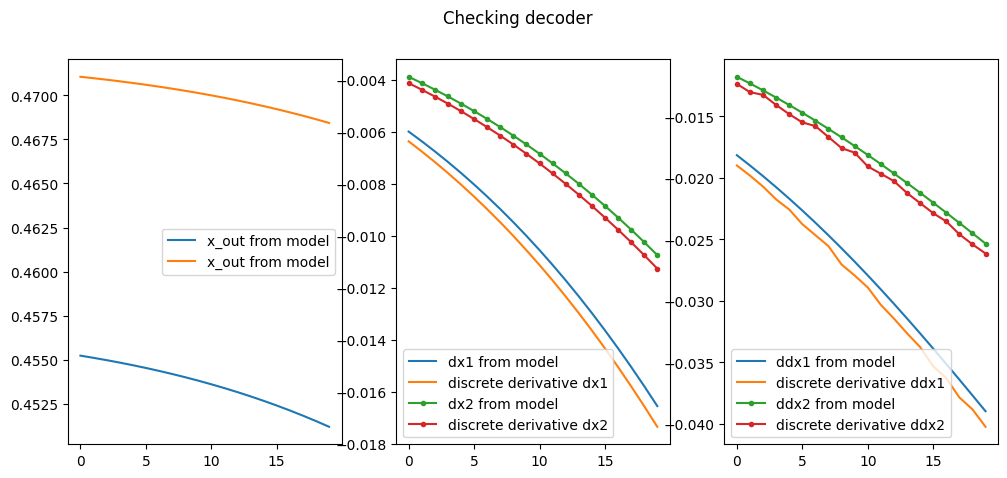

In [137]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(x_check[:20], label="x_out from model")
plt.legend()
plt.subplot(1,3,2)
plt.plot(dx_check[:20,0], label="dx1 from model")
plt.plot(discrete_dx_check[:20,0], label="discrete derivative dx1")
plt.plot(dx_check[:20,1],".-" ,label="dx2 from model")
plt.plot(discrete_dx_check[:20,1],".-" ,label="discrete derivative dx2")
plt.legend()
plt.subplot(1,3,3)
plt.plot(ddx_check[:20,0], label="ddx1 from model")
plt.plot(discrete_ddx_check[:20,0], label="discrete derivative ddx1")
plt.plot(ddx_check[:20,1],".-" ,label="ddx2 from model")
plt.plot(discrete_ddx_check[:20,1], ".-",label="discrete derivative ddx2")
plt.legend()
plt.suptitle("Checking decoder")
plt.show()

As can be seen from the plots above, derivatives obtained from the model (propagated time derivatives) match quite well with the discrete derivatives, hinting that our implementation is indeed correct :) !

2.4 Implementing `SINDyAutoencoder`:

In [138]:
# let' redefine our term_vector function to deal with tensors
# we would need it later in our SINDy-Autoencoder function
def sin_term_torch(z):
    return torch.sin(z)

def cos_term_torch(z):
    return torch.cos(z)

def square(z):
    return z * z

def z_times_dzdt(z, dzdt):
    return z * dzdt

def term_vector_torch(z, dzdt):
    to_return = torch.stack([
        torch.ones_like(z), z, dzdt, sin_term_torch(z),
        square(z), z_times_dzdt(z, dzdt),
        z * sin_term_torch(z), square(dzdt),
        dzdt * sin_term_torch(z),
        sin_term_torch(z) * sin_term_torch(z)
    ], dim=1)

    return to_return

In [139]:
import torch.nn as nn
import torch.nn.init as init

class SINDyAutoencoder(nn.Module):
    def __init__(self, input_size_data_domain, encoder_hidden_sizes_list,
                 input_size_sindy, output_size_sindy,
                 ):
        super(SINDyAutoencoder, self).__init__()

        # Create encoder
        self.encoder = Encoder(input_size=input_size_data_domain,
                               num_layers=len(encoder_hidden_sizes_list),
                               hidden_size_list=encoder_hidden_sizes_list)

        # Initialize the internal SINDy instance from Task 1
        self.sindy = SINDy(input_size=input_size_sindy, output_size=output_size_sindy)

        # Create decoder
        self.decoder = Decoder(num_layers=len(encoder_hidden_sizes_list),
                               hidden_size_list=encoder_hidden_sizes_list,
                               output_size= input_size_data_domain)

    def forward(self, x, dx, ddx):
        # Pass input through the encoder
        #print("inside encoder x.size():",x.size())
        z, dz, ddz = self.encoder(x, dx, ddx)
        #print("encoder worked fine so far :)")

        # Compute z_ddot using the internal SINDy instance
        #AWe need to CREATE THE TERM VECTOR WHICH WOULD THEN BE SENT TO "SELF.SINDY()".
        term_vector_z= term_vector_torch(z,dz)
        term_vector_z= term_vector_z.squeeze(-1)# this step is important

        #print("term_vector_z.size:", term_vector_z.size())
        #print("let's check whether sindy worked?")
        z_ddot_sindy = self.sindy(term_vector_z)
        #print("sindy worked fine so far :) ")

        #print("z_ddot_sindy.shape():",z_ddot_sindy.size())

        # Pass (z_ddot_sindy, z_dot, z_ddot) through the decoder
        reconstructed_x, reconstructed_dx, reconstructed_ddx = self.decoder(z,
                                                                            dz,
                                                                            z_ddot_sindy)#self.decoder(z, dz, ddz)

        #return reconstructed_x, reconstructed_dx, reconstructed_ddx, z, dz, ddz
        return reconstructed_x, reconstructed_ddx, ddz, z_ddot_sindy

In [140]:
def loss_function_sindy_autoencoder(x_true, x_reconstructed,
                                    ddz_encoder, ddz_sindy,
                                    ddx_true, ddx_reconstructed,
                                    sindy_model_coefficients,
                                    lambda_ddz, lambda_ddx, lambda_L1):
  mse_reconstruction_x= (x_true-x_reconstructed)**2
  mse_ddz= (ddz_encoder-ddz_sindy)**2
  mse_reconstruction_ddx= (ddx_true-ddx_reconstructed)**2

  l1_norm= torch.norm(sindy_model_coefficients, p=1).item()
  total_loss= torch.mean(mse_reconstruction_x + lambda_ddz*mse_ddz +
                         lambda_ddx*mse_reconstruction_ddx) + lambda_L1*l1_norm
  return total_loss

Let's create the dataset and the dataloaders for the SINDyAutoencoder model.

In [141]:
### creating data-set for the SINDYAutoencoder model
## recall the shape of z, dzdt and d2zdt
print("Concatenated z:")
print(concatenated_z.shape)
print("Concatenated dzdt:")
print(concatenated_dzdt.shape)
print("Concatenated d2zdt:")
print(concatenated_d2zdt.shape)

Concatenated z:
(25000, 1)
Concatenated dzdt:
(25000, 1)
Concatenated d2zdt:
(25000, 1)


In [142]:
# creating data in cartesian coordinates
X,DX,DDX= cartesian_embedding(concatenated_z,concatenated_dzdt,concatenated_d2zdt)
X.shape, DX.shape, DDX.shape

((25000, 2), (25000, 2), (25000, 2))

In [143]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

#defining our custom dataset
class CustomDataset_SINDY_AE(Dataset):
    def __init__(self, data_x1, data_x2, data_x3):
        self.data_x1 = data_x1
        self.data_x2 = data_x2
        self.data_x3 = data_x3

    def __len__(self):
        # all components have the same length
        return len(self.data_x1)

    def __getitem__(self, idx):
        sample_x1 = self.data_x1[idx]
        sample_x2 = self.data_x2[idx]
        sample_x3 = self.data_x3[idx]

        return sample_x1, sample_x2, sample_x3

In [166]:
### CREATING DATALOADERS FOR SINDyAUTOENCODER MODEL
# Do I need to shuffle the data (I will see to that. I think I might need to)
X_train_sindyAE, X_test_sindyAE= train_test_split(X, test_size=0.3,shuffle=False)
DX_train_sindyAE, DX_test_sindyAE= train_test_split(DX, test_size=0.3,shuffle=False)
DDX_train_sindyAE, DDX_test_sindyAE= train_test_split(DDX, test_size=0.3,shuffle=False)

# convert to torch tensors
X_train_sindyAE_torch = torch.Tensor(X_train_sindyAE)
X_test_sindyAE_torch = torch.Tensor(X_test_sindyAE)

DX_train_sindyAE_torch = torch.Tensor(DX_train_sindyAE)
DX_test_sindyAE_torch = torch.Tensor(DX_test_sindyAE)

DDX_train_sindyAE_torch = torch.Tensor(DDX_train_sindyAE)
DDX_test_sindyAE_torch = torch.Tensor(DDX_test_sindyAE)

# batchsize
batch_size= 32#X_train_sindyAE.shape[0]

# training dataset and dataloader
train_dataset_sindyAE= CustomDataset_SINDY_AE(X_train_sindyAE_torch,
                                              DX_train_sindyAE_torch,
                                              DDX_train_sindyAE_torch)
train_sindyAE_dl= DataLoader(train_dataset_sindyAE, batch_size=batch_size, shuffle=False)

test_dataset_sindyAE= CustomDataset_SINDY_AE(X_test_sindyAE_torch,
                                              DX_test_sindyAE_torch,
                                              DDX_test_sindyAE_torch)
test_sindyAE_dl= DataLoader(test_dataset_sindyAE, batch_size=batch_size, shuffle=False)



In [145]:
X_train_sindyAE.shape

(17500, 2)

In [ ]:
# input_size=2
# num_layers=1
# hidden_size_list=[1]
# encoder_check = Encoder(input_size, num_layers, hidden_size= hidden_size_list)

# encoder_check.eval()
# with torch.no_grad():
#   for batch in train_sindyAE_dl:
#     x, dx, ddx= batch
#     z, dz, ddz = encoder_check(x, dx, ddx)

# z.size(), dz.size(), ddz.size()
# term_vector_check= term_vector_torch(z,dz)
# term_vector_check.size()

within sindy autoencoder, after the encoding step, we would be required to create the X dataset (term matrix) for the SINDy class. Let's do that as well

In [ ]:
# print("Concatenated z:")
# print(concatenated_z.shape)
# print("Concatenated dzdt:")
# print(concatenated_dzdt.shape)
# print("Concatenated d2zdt:")
# print(concatenated_d2zdt.shape)

# term_vector_check=term_vector_torch(z=torch.FloatTensor(concatenated_z),
#                                     dzdt=torch.FloatTensor(concatenated_dzdt))
# term_vector_check=term_vector_check.squeeze(-1)
# term_vector_check.shape

# print(term_vector_check)# this is coming out to ve
#DONE: I have Incorporated this code in the function

Let's define `train_sindy_autoencoder` function.

Note for me: Dont forget to change the batchsize !

In [181]:
import torch
import torch.optim as optim

def train_and_validate_sindy_autoencoder(model, train_dataloader, val_dataloader,
                                         num_epochs=10, print_epoch=1, learning_rate=0.001,
                                         lambda_ddz=0.00005, lambda_ddx=0.0005, lambda_L1=0.00005,
                                         thresholding=None,
                                         interval_ST=500,
                                         threshold_a=0.1,
                                         threshold_b=0.002,
                                         patience_ptat=1000,
                                         refinement_epoch=5000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    coefficient_values_over_time=[]

    if thresholding == "patient":
      E_a= torch.zeros_like(model.sindy.coefficients)
      E_b= torch.zeros_like(model.sindy.coefficients)
      previous_coefficients = torch.zeros_like(model.sindy.coefficients)

    for epoch in tqdm(range(1, num_epochs + 1)):  # Wrap the loop with tqdm

        model.train()
        total_train_loss = 0.0

        if epoch>=refinement_epoch:
          lambda_L1=0.0

        # Training loop
        for batch in train_dataloader:
            x_true, dx_true, ddx_true = batch
            x_true, dx_true, ddx_true = x_true.to(device), dx_true.to(device), ddx_true.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            reconstructed_x, reconstructed_ddx, ddz_encoder, z_ddot_sindy = model(x_true, dx_true, ddx_true)
            sindy_model_coeffs=model.sindy.coefficients.detach()


            # Calculate loss
            loss = loss_function_sindy_autoencoder(x_true=x_true, x_reconstructed=reconstructed_x,
                                                   ddz_encoder=ddz_encoder, ddz_sindy=z_ddot_sindy,
                                                   ddx_true=ddx_true, ddx_reconstructed=reconstructed_ddx,
                                                   sindy_model_coefficients=sindy_model_coeffs,
                                                   lambda_ddz=lambda_ddz, lambda_ddx=lambda_ddx,
                                                   lambda_L1=lambda_L1)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Calculate average training loss for the epoch
        average_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(average_train_loss)

        # Validation loop
        # if epoch % print_epoch == 0:
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for val_batch in val_dataloader:
                x_val, dx_val, ddx_val = val_batch
                x_val, dx_val, ddx_val = x_val.to(device), dx_val.to(device), ddx_val.to(device)

                # Forward pass for validation
                val_reconstructed_x, val_reconstructed_ddx, val_ddz_encoder, val_z_ddot_sindy = model(x_val, dx_val, ddx_val)
                sindy_model_coeffs=model.sindy.coefficients.detach()

                # Calculate validation loss
                val_loss = loss_function_sindy_autoencoder(x_true= x_val, x_reconstructed=val_reconstructed_x,
                                                            ddz_encoder=val_ddz_encoder,
                                                            ddz_sindy= val_z_ddot_sindy,
                                                            ddx_true=ddx_val,
                                                            ddx_reconstructed=val_reconstructed_ddx,
                                                            sindy_model_coefficients=sindy_model_coeffs,
                                                            lambda_ddz=lambda_ddz, lambda_ddx=lambda_ddx,
                                                            lambda_L1=lambda_L1)

                total_val_loss += val_loss.item()

        # Calculate average validation loss for the epoch
        average_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(average_val_loss)

        if epoch % print_epoch == 0:
          print(f'\nEpoch {epoch}/{num_epochs}, Avg. Training Loss: {average_train_loss}, Avg. Validation Loss: {average_val_loss}')


        ### Adding thresholding
        #### one thing which is not very clear is whether I need to shut it off or not?
        if epoch< refinement_epoch:
          if thresholding == "sequential":
            if (epoch % interval_ST ==0):
              #print("\n------Applying sequential thresholding-----")
              sequential_thresholding(model.sindy.coefficients, model.sindy.mask,
                                      epoch, threshold_a=threshold_a,
                                      interval=interval_ST)
          elif thresholding == "patient":
            previous_coefficients= PTA_thresholding(coefficients=model.sindy.coefficients,
                                                    mask=model.sindy.mask,
                                                    epoch=epoch,
                                                    threshold_a=threshold_a,
                                                    threshold_b=threshold_b,
                                                    patience_p=patience_ptat,
                                                    E_a=E_a,E_b=E_b,
                                                    previous_coefficients=previous_coefficients)

        ### save the coefficients values throughout the training.
        coefficients_snapshot= model.sindy.coefficients.detach().clone().cpu()
        mask_on_cpu = model.sindy.mask.detach().cpu().int().float()
        coeffs_to_append= (coefficients_snapshot * mask_on_cpu).numpy().flatten()
        coefficient_values_over_time.append(coeffs_to_append)
        ## prinintng the coefficients
        print("coefficient (unmasked):")
        print(coefficients_snapshot)
        print("masks:")
        print(model.sindy.mask.detach().cpu())
        print("coefficients masked:")
        print(coeffs_to_append)
        print("_"*10)


    return train_losses, val_losses, coefficient_values_over_time

In [ ]:
# class SINDyAutoencoder(nn.Module):
#     def __init__(self, input_size_data_domain, encoder_hidden_sizes_list,
#                  input_size_sindy, output_size_sindy,
#                  ):

In [182]:
input_size_data_domain=2
encoder_hidden_sizes_list=[1]
input_size_sindy=10
output_size_sindy=1#
# print(model_SINDY_AE_ST)

In [ ]:
# train_and_validate_sindy_autoencoder(model, train_dataloader, val_dataloader,
#                                          num_epochs=10, print_epoch=1, learning_rate=0.001,
#                                          lambda_ddz=0.00005, lambda_ddx=0.0005, lambda_L1=0.00005,
#                                          thresholding=None,
#                                          interval_ST=500,
#                                          threshold_a=0.1,
#                                          threshold_b=0.002,
#                                          paitence_ptat=1000,
#                                          refinement_epoch=5000)

  3%|▎         | 1/30 [00:03<01:52,  3.89s/it]

coefficient (unmasked):
tensor([[0.5818, 0.5985, 0.9324, 0.5975, 0.6110, 0.9347, 0.6101, 0.7613, 0.9345,
         0.6093]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[0.58184284 0.59852105 0.9324331  0.59751344 0.6109779  0.9347127
 0.6101317  0.76132524 0.93451375 0.6092956 ]
__________


  7%|▋         | 2/30 [00:07<01:42,  3.65s/it]

coefficient (unmasked):
tensor([[0.2892, 0.2902, 0.8595, 0.2917, 0.2935, 0.8635, 0.2945, 0.6125, 0.8632,
         0.2956]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[0.28921264 0.29023015 0.8595478  0.291662   0.29345363 0.863508
 0.29448688 0.61248636 0.86316234 0.29559097]
__________


 10%|█         | 3/30 [00:10<01:31,  3.41s/it]

coefficient (unmasked):
tensor([[0.1432, 0.1026, 0.7726, 0.1099, 0.0776, 0.7788, 0.0833, 0.5610, 0.7783,
         0.0892]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[0.14316231 0.10255373 0.7726304  0.10991503 0.07761198 0.7788229
 0.08330601 0.5610093  0.7782526  0.0892038 ]
__________


 13%|█▎        | 4/30 [00:13<01:25,  3.30s/it]

coefficient (unmasked):
tensor([[ 0.1159,  0.0095,  0.6661,  0.0260, -0.0593,  0.6760, -0.0467,  0.6151,
          0.6751, -0.0337]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.11592644  0.0095469   0.66612256  0.02597347 -0.059276    0.6760417
 -0.04669854  0.61512923  0.67507046 -0.03368546]
__________


 17%|█▋        | 5/30 [00:17<01:26,  3.44s/it]

coefficient (unmasked):
tensor([[ 0.1623, -0.0331,  0.5438, -0.0049, -0.1589,  0.5574, -0.1377,  0.7696,
          0.5561, -0.1159]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.16230458 -0.03307942  0.5438008  -0.00493112 -0.1588628   0.5574278
 -0.13774885  0.7696303   0.5560551  -0.11585747]
__________


 20%|██        | 6/30 [00:20<01:21,  3.39s/it]

coefficient (unmasked):
tensor([[ 0.2463, -0.0589,  0.4194, -0.0171, -0.2515,  0.4325, -0.2209,  0.9819,
          0.4311, -0.1890]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.24628724 -0.05893026  0.41938135 -0.01709846 -0.25149712  0.4324608
 -0.22088039  0.9819008   0.43108022 -0.18903384]
__________


 23%|██▎       | 7/30 [00:23<01:16,  3.31s/it]

coefficient (unmasked):
tensor([[ 0.3468, -0.0837,  0.3071, -0.0271, -0.3489,  0.3127, -0.3086,  1.1997,
          0.3118, -0.2665]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.3467549  -0.08374219  0.30706987 -0.02710468 -0.34891436  0.31266847
 -0.30858552  1.1997057   0.31181586 -0.26647106]
__________


 27%|██▋       | 8/30 [00:26<01:11,  3.24s/it]

coefficient (unmasked):
tensor([[ 0.4507, -0.1112,  0.2149, -0.0395, -0.4505,  0.2081, -0.4009,  1.3907,
          0.2079, -0.3490]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.45072114 -0.11121176  0.21485128 -0.03953097 -0.4505062   0.2080649
 -0.4009404   1.3907275   0.20790616 -0.34895512]
__________


 30%|███       | 9/30 [00:30<01:11,  3.42s/it]

coefficient (unmasked):
tensor([[ 0.5480, -0.1392,  0.1450, -0.0531, -0.5502,  0.1269, -0.4924,  1.5361,
          0.1269, -0.4315]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.54797214 -0.13922279  0.14504541 -0.05308162 -0.5502484   0.12689304
 -0.49242398  1.5360994   0.12692209 -0.43150786]
__________


 33%|███▎      | 10/30 [00:33<01:06,  3.34s/it]

coefficient (unmasked):
tensor([[ 0.6303, -0.1632,  0.0961, -0.0638, -0.6408,  0.0732, -0.5760,  1.6249,
          0.0726, -0.5074]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.6302682  -0.16320851  0.09606864 -0.0638094  -0.64080596  0.07322224
 -0.5759689   1.6248554   0.07264954 -0.50737375]
__________


 37%|███▋      | 11/30 [00:37<01:02,  3.29s/it]

coefficient (unmasked):
tensor([[ 0.6925, -0.1784,  0.0637, -0.0672, -0.7164,  0.0431, -0.6458,  1.6607,
          0.0416, -0.5708]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.6924748  -0.17840876  0.06369174 -0.06723095 -0.71636593  0.04313406
 -0.6457981   1.6607196   0.04163221 -0.57083863]
__________


 40%|████      | 12/30 [00:40<00:58,  3.24s/it]

coefficient (unmasked):
tensor([[ 0.7330, -0.1820,  0.0428, -0.0605, -0.7747,  0.0281, -0.6996,  1.6638,
          0.0258, -0.6195]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.7329997  -0.18203431  0.04284732 -0.0604671  -0.77474177  0.02814371
 -0.69959754  1.6638031   0.02582858 -0.6194632 ]
__________


 43%|████▎     | 13/30 [00:43<00:58,  3.41s/it]

coefficient (unmasked):
tensor([[ 0.7533, -0.1740,  0.0293, -0.0432, -0.8175,  0.0214, -0.7387,  1.6573,
          0.0184, -0.6544]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.75326    -0.17404322  0.02925355 -0.04315145 -0.8174532   0.0213636
 -0.7386865   1.6572846   0.01842655 -0.6543544 ]
__________


 47%|████▋     | 14/30 [00:47<00:53,  3.33s/it]

coefficient (unmasked):
tensor([[ 0.7567, -0.1562,  0.0200, -0.0167, -0.8480,  0.0189, -0.7664,  1.6569,
          0.0154, -0.6786]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.7567199  -0.1562285   0.01996048 -0.01669762 -0.84802264  0.01886866
 -0.76637864  1.6569452   0.01544353 -0.6786015 ]
__________


 50%|█████     | 15/30 [00:50<00:48,  3.27s/it]

coefficient (unmasked):
tensor([[ 0.7477, -0.1310,  0.0131,  0.0167, -0.8703,  0.0187, -0.7863,  1.6701,
          0.0148, -0.6957]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.74766463 -0.1310418   0.01314992  0.01674904 -0.8702512   0.01865955
 -0.7863073   1.6700743   0.01482251 -0.6956543 ]
__________


 53%|█████▎    | 16/30 [00:53<00:45,  3.24s/it]

coefficient (unmasked):
tensor([[ 0.7302, -0.1008,  0.0078,  0.0550, -0.8872,  0.0197, -0.8015,  1.6977,
          0.0155, -0.7084]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.7302452  -0.10083244  0.00776086  0.05502144 -0.88724226  0.01972524
 -0.8014662   1.6976871   0.01551472 -0.708399  ]
__________


 57%|█████▋    | 17/30 [00:57<00:44,  3.41s/it]

coefficient (unmasked):
tensor([[ 0.7080, -0.0675,  0.0032,  0.0963, -0.9011,  0.0215, -0.8139,  1.7372,
          0.0170, -0.7188]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.7080055  -0.06748801  0.00318482  0.09629772 -0.9010881   0.02153304
 -0.8139028   1.7371974   0.01696449 -0.71883506]
__________


 60%|██████    | 18/30 [01:00<00:39,  3.32s/it]

coefficient (unmasked):
tensor([[ 6.8373e-01, -3.2373e-02, -9.3258e-04,  1.3920e-01, -9.1296e-01,
          2.3782e-02, -8.2477e-01,  1.7847e+00,  1.8857e-02, -7.2812e-01]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 6.8372530e-01 -3.2372534e-02 -9.3257712e-04  1.3919668e-01
 -9.1295505e-01  2.3782473e-02 -8.2477450e-01  1.7847376e+00
  1.8857017e-02 -7.2811973e-01]
__________


 63%|██████▎   | 19/30 [01:03<00:35,  3.26s/it]

coefficient (unmasked):
tensor([[ 0.6594,  0.0036, -0.0048,  0.1827, -0.9233,  0.0263, -0.8346,  1.8365,
          0.0210, -0.7368]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.6593851   0.00355192 -0.00480475  0.18268232 -0.923313    0.02629446
 -0.8345642   1.836504    0.02100458 -0.7367568 ]
__________


 67%|██████▋   | 20/30 [01:06<00:33,  3.32s/it]

coefficient (unmasked):
tensor([[ 0.6362,  0.0395, -0.0086,  0.2258, -0.9322,  0.0290, -0.8433,  1.8891,
          0.0233, -0.7448]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.6361531   0.03950192 -0.0085608   0.22584797 -0.93220115  0.02896335
 -0.84333724  1.88913     0.02329756 -0.7448454 ]
__________


 70%|███████   | 21/30 [01:10<00:30,  3.38s/it]

coefficient (unmasked):
tensor([[ 0.6144,  0.0746, -0.0123,  0.2677, -0.9395,  0.0317, -0.8510,  1.9395,
          0.0257, -0.7523]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.6144306   0.07464582 -0.01226432  0.26769924 -0.93951195  0.03173202
 -0.851015    1.939471    0.02568038 -0.7523491 ]
__________


 73%|███████▎  | 22/30 [01:13<00:26,  3.30s/it]

coefficient (unmasked):
tensor([[ 0.5941,  0.1081, -0.0159,  0.3072, -0.9451,  0.0346, -0.8575,  1.9843,
          0.0281, -0.7592]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.59411526  0.10812496 -0.01590226  0.3072004  -0.9451181   0.03457298
 -0.857491    1.9843282   0.02813306 -0.7591954 ]
__________


 77%|███████▋  | 23/30 [01:16<00:22,  3.26s/it]

coefficient (unmasked):
tensor([[ 0.5750,  0.1393, -0.0194,  0.3436, -0.9488,  0.0375, -0.8625,  2.0207,
          0.0306, -0.7651]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.575017    0.13931446 -0.01938294  0.34357724 -0.9487781   0.03746108
 -0.86251444  2.0206575   0.03064148 -0.7651233 ]
__________


 80%|████████  | 24/30 [01:20<00:20,  3.35s/it]

coefficient (unmasked):
tensor([[ 0.5570,  0.1679, -0.0226,  0.3764, -0.9502,  0.0403, -0.8657,  2.0465,
          0.0332, -0.7697]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.55703956  0.16785301 -0.02258134  0.3763694  -0.95020777  0.04033942
 -0.86574036  2.0464704   0.03315706 -0.76973295]
__________


 83%|████████▎ | 25/30 [01:23<00:16,  3.37s/it]

coefficient (unmasked):
tensor([[ 0.5401,  0.1934, -0.0254,  0.4052, -0.9494,  0.0431, -0.8670,  2.0619,
          0.0356, -0.7728]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.54013133  0.19343238 -0.025397    0.4052362  -0.9493634   0.04310956
 -0.86702955  2.061891    0.03558251 -0.77278155]
__________


 87%|████████▋ | 26/30 [01:26<00:13,  3.30s/it]

coefficient (unmasked):
tensor([[ 0.5242,  0.2158, -0.0278,  0.4299, -0.9465,  0.0457, -0.8665,  2.0693,
          0.0378, -0.7743]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.5242075   0.21578333 -0.02777848  0.4299452  -0.9464932   0.04565508
 -0.8665026   2.0692985   0.0377952  -0.77425855]
__________


 90%|█████████ | 27/30 [01:29<00:09,  3.25s/it]

coefficient (unmasked):
tensor([[ 0.5091,  0.2348, -0.0297,  0.4505, -0.9419,  0.0479, -0.8643,  2.0723,
          0.0397, -0.7742]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.50911117  0.23483124 -0.02971115  0.4504988  -0.94186497  0.04787064
 -0.86430514  2.0722747   0.03968074 -0.7741761 ]
__________


 93%|█████████▎| 28/30 [01:33<00:06,  3.38s/it]

coefficient (unmasked):
tensor([[ 0.4946,  0.2507, -0.0312,  0.4671, -0.9356,  0.0497, -0.8605,  2.0742,
          0.0412, -0.7725]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.49461398  0.2506796  -0.03118997  0.46707633 -0.93560946  0.04967649
 -0.860466    2.0742292   0.04115025 -0.77245647]
__________


 97%|█████████▋| 29/30 [01:36<00:03,  3.35s/it]

coefficient (unmasked):
tensor([[ 0.4805,  0.2635, -0.0322,  0.4799, -0.9278,  0.0510, -0.8549,  2.0776,
          0.0421, -0.7690]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.48047113  0.26347062 -0.0321999   0.47987565 -0.9277568   0.05101759
 -0.8549442   2.0776145   0.04214066 -0.76898545]
__________


100%|██████████| 30/30 [01:40<00:00,  3.33s/it]

coefficient (unmasked):
tensor([[ 0.4665,  0.2733, -0.0327,  0.4890, -0.9183,  0.0519, -0.8477,  2.0838,
          0.0426, -0.7637]])
masks:
tensor([[True, True, True, True, True, True, True, True, True, True]])
coefficients masked:
[ 0.46649432  0.27330336 -0.03271555  0.48903018 -0.91830426  0.05185515
 -0.8476939   2.0838168   0.04260587 -0.7636678 ]
__________


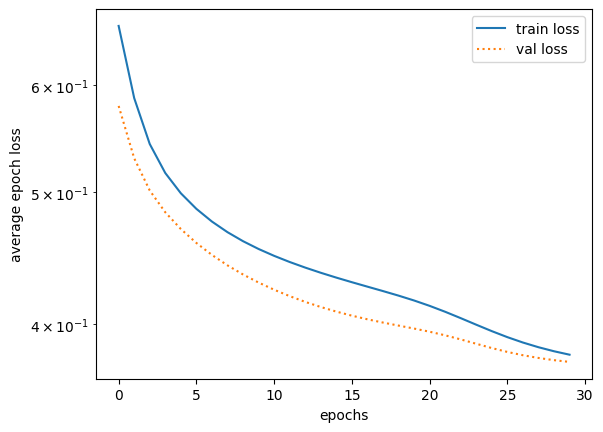

In [188]:
model_SINDY_AE_ST= SINDyAutoencoder(input_size_data_domain=input_size_data_domain,
                                 encoder_hidden_sizes_list=encoder_hidden_sizes_list,
                                 input_size_sindy=input_size_sindy, output_size_sindy=output_size_sindy
                                 )

train_losses_SINDYAE_ST, val_losses_SINDYAE_ST, masked_coeffs_SINDYAE_ST = train_and_validate_sindy_autoencoder(model=model_SINDY_AE_ST,
                                                                train_dataloader=train_sindyAE_dl,
                                                                val_dataloader=test_sindyAE_dl,
                                         num_epochs=30,print_epoch=101, learning_rate=0.001,
                                         lambda_ddz=0.00005, lambda_ddx=0.0005, lambda_L1=0,
                                          thresholding="patient",
                                          interval_ST=50, patience_ptat=20,
                                          refinement_epoch=20)
plot_train_and_val_loss(train_losses_SINDYAE_ST, val_losses_SINDYAE_ST)

In [189]:
model_SINDY_AE_ST.sindy.coefficients, model_SINDY_AE_ST.sindy.mask

(Parameter containing:
 tensor([[ 0.4665,  0.2733, -0.0327,  0.4890, -0.9183,  0.0519, -0.8477,  2.0838,
           0.0426, -0.7637]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[True, True, True, True, True, True, True, True, True, True]],
        device='cuda:0'))

Text(0.5, 1.0, 'SINDY with ST')

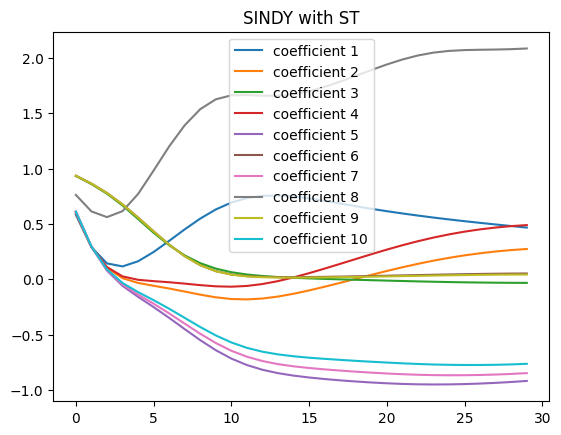

In [190]:
masked_coeffs_SINDYAE_ST= np.array(masked_coeffs_SINDYAE_ST)
for i in range(0,10):
    plt.plot(masked_coeffs_SINDYAE_ST[:,i], label=f"coefficient {i+1}")
plt.legend()
plt.title("SINDY with ST")

# Everything below is not important

In [ ]:
# import numpy as np
# from scipy.integrate import odeint
# import matplotlib.pyplot as plt

# # Define the ODE system
# def my_ode(y, t):
#     dydt = -2 * y  # Example: simple exponential decay
#     return dydt

# # Initial condition
# y0 = 1.0

# # Time points
# t = np.linspace(0, 5, 101)

# # Solve the ODE using odeint
# solution = odeint(my_ode, y0, t)

# # Plot the solution
# plt.plot(t, solution)
# plt.xlabel('Time')
# plt.ylabel('y(t)')
# plt.title('ODE Solution')
# plt.show()
